## Decision making in low-rank recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# plt.style.use('dark_background')

### Perceptual decision makingg

__1. Create a function for generating the data.__

In [8]:
# defining standard deviation and strength of stimulus

std = 0.03
stim_strength = std * np.hstack((-np.flip(2**np.arange(0,5)), 2**np.arange(0,5)))


In [ ]:

def generate_data(trials, length, stim_strength, std = 0.03):
    """
    ksi is a normally distr noise with sigma 0.03.
    u is an input
    û is the stimulis strength
    y is the target, i.e. the sign of û
    """
    ksi = std * np.random.randn(trials, length)
    
  
    û_value = np.random.choice(stim_strength, trials)
    û = np.full_like(ksi, 0)
    y = np.full_like(ksi, 1)
    for i in range(trials):
        û[i, 5:46] = û_value[i]
        y[i] = np.sign(û_value[i]) * y[i]
    
    return  û + ksi, y


In [11]:
# generate data

T = 80
trials = 5
u, y = generate_data(trials, T, stim_strength)
time = np.arange(0,T)


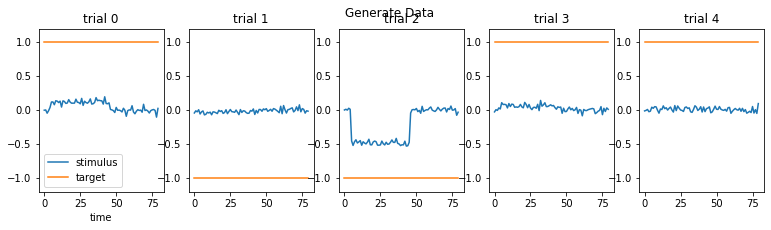

In [13]:
# plot

fig, axs = plt.subplots(1, trials, figsize=(13,3))

fig.suptitle("Generate Data")

for i in range(trials):
    axs[i].plot(time, u[i,:], label="stimulus")
    axs[i].plot(time, y[i,:], label="target")
    axs[i].set_title(f"trial {i}")
    axs[i].set_ylim(-1.2, 1.2)
axs[0].set_xlabel("time")
axs[0].legend()
plt.show()

__2. Implement the recurrent neural network in your favorite deep learning library.__

In [14]:
# Define the input-to-hidden, hidden-to-hidden and hidden-to-output matrices.
I = lambda N: np.random.normal(0, 1, N)
J = lambda N: 1 / N * (np.random.normal(0, 1, N).reshape(N, 1)@np.random.normal(0, 1, N).reshape(N, 1).T)
w = lambda N: np.random.normal(0, 1, N)

# Define the functions.
phi = lambda x: np.tanh(x)
dynamics = lambda u, x, N, t, tau=100: (-x + J(N)@phi(x) + I(N)*u[t]) / tau
output = lambda x, N: 1 / N * w(N)@phi(x)

In [15]:
def forward_euler(u, x, N, dt=20, tau=100):
    x = x + dt * dynamics(u, x, N, tau)
    return x

In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, I, J, w, x):
        super(RNN, self).__init__()
        
        # Defining the number of layers and the nodes in each layer.
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layers.
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, bias=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Initialization of weights and biases.
        self.rnn.weight_ih_I = torch.from_numpy(I.T)
        self.rnn.weight_hh_I = torch.from_numpy(J)
        self.fc.weight.data = torch.from_numpy(w.reshape(output_size, hidden_size)).float()
        
        self.bias_ih_I = torch.from_numpy(-x)
        self.bias_hh_I = torch.from_numpy(np.zeros(hidden_size))
        self.fc.bias.data = torch.from_numpy(np.zeros(output_size)).float()
        
    def forward(self, u, X):
        # Initializing input and hidden state to fit into the model.
        input = torch.from_numpy((u.T.reshape(u.T.shape[0], u.T.shape[1], self.input_size)).astype(np.float32))
        hidden = torch.from_numpy((X[-1, :, :].reshape(self.num_layers, X.shape[1], X.shape[2])).astype(np.float32))
        
        # Input-to-hidden propagation.
        out, h_0 = self.rnn(input, hidden)
        
        # Reshaping the outputs so that it can fit into the fully connected layer.
        out = out[:, -1, :]
        out = 1 / self.hidden_size * self.fc(out)
        
        return out